In [1]:
%matplotlib inline
import os
import sys
import random
import warnings

import numpy as np

import matplotlib.pyplot as plt

from itertools import chain
from skimage import filters,exposure,segmentation,color,io
from skimage.io import imread, imshow, imread_collection, concatenate_images, imsave
from skimage import filters,exposure
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input,GaussianNoise,BatchNormalization
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K

from keras.optimizers import *

import tensorflow as tf

from sklearn.metrics import f1_score

#seed_ = 42
#random.seed = seed_
#np.random.seed = seed_

Using TensorFlow backend.


In [2]:
IMG_HEIGHT = 400
IMG_WIDTH = 400
IMG_CHANNELS = 3

In [3]:
# Helper functions

def load_image(infilename):
    data = imread(infilename)[:,:,:IMG_CHANNELS]
    return data

def load_image_label(infilename):
    data = imread(infilename)
    return data

def img_float_to_uint8(img):
    rimg = img - np.min(img)
    rimg = (rimg / np.max(rimg) * 255).round().astype(np.uint8)
    return rimg

# Concatenate an image and its groundtruth
def concatenate_images(img, gt_img):
    nChannels = len(gt_img.shape)
    w = gt_img.shape[0]
    h = gt_img.shape[1]
    if nChannels == 3:
        cimg = np.concatenate((img, gt_img), axis=1)
    else:
        gt_img_3c = np.zeros((w, h, 3), dtype=np.uint8)
        gt_img8 = img_float_to_uint8(gt_img)          
        gt_img_3c[:,:,0] = gt_img8
        gt_img_3c[:,:,1] = gt_img8
        gt_img_3c[:,:,2] = gt_img8
        img8 = img_float_to_uint8(img)
        cimg = np.concatenate((img8, gt_img_3c), axis=1)
    return cimg

def img_crop(im, w, h):
    list_patches = []
    imgwidth = im.shape[0]
    imgheight = im.shape[1]
    is_2d = len(im.shape) < 3
    for i in range(0,imgheight,h):
        for j in range(0,imgwidth,w):
            if is_2d:
                im_patch = im[j:j+w, i:i+h]
            else:
                im_patch = im[j:j+w, i:i+h, :]
            list_patches.append(im_patch)
    return list_patches

In [4]:
# Image processing tools
def constrast_streching(img):
    # Contrast stretching
    p2, p98 = np.percentile(img, (2, 98))
    img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))
    return img_rescale

def k_means(img):
    # K-means
    labels_kmeans = segmentation.slic(img, compactness=20, n_segments=1000)
    img_kmeans = color.label2rgb(labels_kmeans, img, kind='avg')
    return img_kmeans

In [5]:
# Loaded a set of images
root_dir = "data/training/"

image_dir = root_dir + "images/"
files = os.listdir(image_dir)
n = min(400, len(files)) # Load maximum 20 images
print("Loading " + str(n) + " images")
imgs = [load_image(image_dir + files[i]) for i in range(n)]
print(files[0])

gt_dir = root_dir + "groundtruth/"
print("Loading " + str(n) + " images")
gt_imgs = [load_image_label(gt_dir + files[i]) for i in range(n)]
print(files[0])


Loading 100 images
satImage_061.png
Loading 100 images
satImage_061.png


In [6]:
# Shuffle the data
def shuffle_data(imgs,gt_imgs):    
    union = [x for x in zip(imgs,gt_imgs)]
    np.random.shuffle(union)
    imgs,gt_imgs = [list(x) for x in zip(*union)]
    return imgs,gt_imgs

In [7]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [8]:
type(imgs[0])

numpy.ndarray

In [9]:
# Make data augmentation
# Parameters
batc_size = 2
val_split = 0.1

In [10]:
# Data format
X_train = np.array(imgs)
Y_train = np.zeros((len(imgs), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
for i in range(len(imgs)):
    mask_ = np.expand_dims(gt_imgs[i], axis=-1)
    Y_train[i] = mask_    

In [11]:
X_train.shape

(100, 400, 400, 3)

In [12]:
idx_x = int(X_train.shape[0]*(1.0-val_split))
idx_y = int(Y_train.shape[0]*(1.0-val_split))
X_TR  = X_train[:idx_x]
Y_TR  = Y_train[:idx_y]
X_VAL = X_train[idx_x:]
Y_VAL = Y_train[idx_y:]

In [13]:
datagen_dict = dict(featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=45,
    vertical_flip=True,
    horizontal_flip=True,
    zoom_range = 0.1,
    width_shift_range = 0.1,
    height_shift_range = 0.1,                
    fill_mode='reflect',
    dtype=np.uint8)

datagenx_tr = ImageDataGenerator(
**datagen_dict)

datageny_tr = ImageDataGenerator(
    **datagen_dict)

datagenx_val = ImageDataGenerator(
    **datagen_dict)

datageny_val = ImageDataGenerator(
    **datagen_dict)

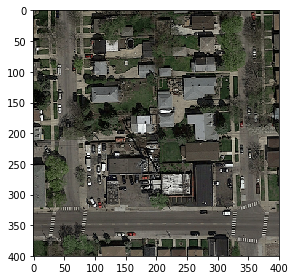

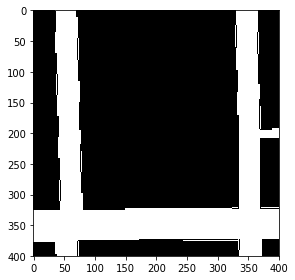

In [14]:
# Check if training data looks all right
ix = random.randint(0, len(imgs) - 1)
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

In [15]:
print(X_train.shape)
print(Y_train.shape)
print(X_train.dtype)
print(Y_train.dtype)

(100, 400, 400, 3)
(100, 400, 400, 1)
uint8
bool


In [16]:
print(len(Y_train[Y_train == True]))

3604158


In [38]:
# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)
n_filter = 16
conv_size = 4
sigma = 
c1 = GaussianNoise(0.05)(s)
c1 = Conv2D(n_filter, (conv_size, conv_size), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
c1 = BatchNormalization()(c1)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(n_filter, (conv_size, conv_size), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
c1 = BatchNormalization()(c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(2*n_filter, (conv_size, conv_size), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = BatchNormalization()(c2)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(2*n_filter, (conv_size, conv_size), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
c2 = BatchNormalization()(c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(4*n_filter, (conv_size, conv_size), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = BatchNormalization()(c3)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(4*n_filter, (conv_size, conv_size), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
c3 = BatchNormalization()(c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(8*n_filter, (conv_size, conv_size), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = BatchNormalization()(c4)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(8*n_filter, (conv_size, conv_size), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
c4 = BatchNormalization()(c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(16*n_filter, (conv_size, conv_size), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = BatchNormalization()(c5)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(16*n_filter, (conv_size, conv_size), activation='elu', kernel_initializer='he_normal', padding='same') (c5)
c5 = BatchNormalization()(c5)

u6 = Conv2DTranspose(8*n_filter, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(8*n_filter, (conv_size, conv_size), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = BatchNormalization()(c6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(8*n_filter, (conv_size, conv_size), activation='elu', kernel_initializer='he_normal', padding='same') (c6)
c6 = BatchNormalization()(c6)

u7 = Conv2DTranspose(4*n_filter, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(4*n_filter, (conv_size, conv_size), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = BatchNormalization()(c7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(4*n_filter, (conv_size, conv_size), activation='elu', kernel_initializer='he_normal', padding='same') (c7)
c7 = BatchNormalization()(c7)

u8 = Conv2DTranspose(2*n_filter, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(2*n_filter, (conv_size, conv_size), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = BatchNormalization()(c8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(2*n_filter, (conv_size, conv_size), activation='elu', kernel_initializer='he_normal', padding='same') (c8)
c8 = BatchNormalization()(c8)

u9 = Conv2DTranspose(n_filter, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(n_filter, (conv_size, conv_size), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = BatchNormalization()(c9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(n_filter, (conv_size, conv_size), activation='elu', kernel_initializer='he_normal', padding='same') (c9)
c9 = BatchNormalization()(c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

SyntaxError: invalid syntax (<ipython-input-38-785e8a59f277>, line 6)

In [39]:
x_tr_gr  = datagenx_tr.flow(X_TR, batch_size=1,seed=1)
y_tr_gr  = datageny_tr.flow(Y_TR, batch_size=1,seed=1)
x_val_gr = datagenx_val.flow(X_VAL, batch_size=1,seed=1)
y_val_gr = datageny_val.flow(Y_VAL, batch_size=1,seed=1)

tr_gr  = zip(x_tr_gr,y_tr_gr)
val_gr = zip(x_val_gr,y_val_gr)

In [40]:
model_file_name = 'unet-od-da-bn.h5'

In [ ]:
# Fit model
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint(model_file_name, verbose=1, save_best_only=True)

#results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=2, epochs=50, 
#                    callbacks=[earlystopper, checkpointer])

results = model.fit_generator(tr_gr,
                    steps_per_epoch=1000,
                    epochs=50,
                    validation_data=val_gr,
                    validation_steps=len(X_VAL),          
                    callbacks=[earlystopper, checkpointer])


Epoch 1/50
 885/1000 [=========================>....] - ETA: 17s - loss: 0.1474 - acc: 0.9181

In [21]:

# Predict on train, val and test
model = load_model(model_file_name)
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)],batch_size=2, verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):],batch_size=2, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
#preds_test_t = (preds_test > 0.5).astype(np.uint8)

10/10 [==============================] - 0s 43ms/step


In [22]:
preds_train_t[0]

array([[[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       ...,

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]]], dtype=uint8)

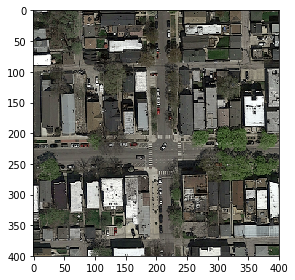

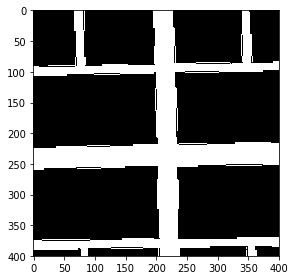

/home/hellgheast/miniconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:77: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


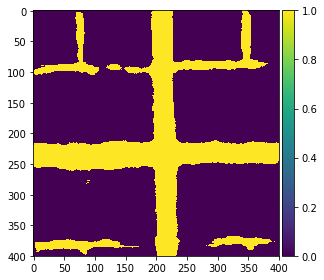

In [23]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

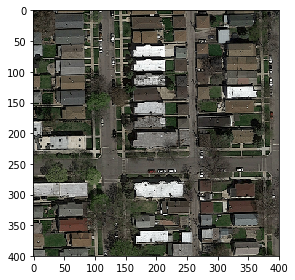

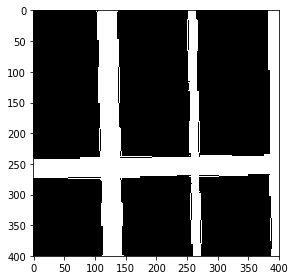

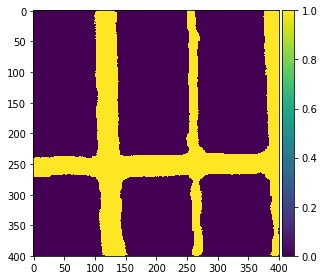

In [24]:
# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()


In [31]:
print(preds_train_t.shape)
print()
print(f1_score(preds_val_t.flatten(), Y_train[int(Y_train.shape[0]*0.9):].flatten(), average="binary"))

(90, 400, 400, 1)

0.8902310854849512


In [32]:
test_path = "data/test_set_images/"
files = os.listdir(test_path)
print("Loading " + str(len(files)) + " images")
imgs = []
for i in range(len(files)):
    imgs.append(load_image(test_path + "test_" + str(i+1) + "/test_" + str(i+1) + ".png"))
print(files)
print(imgs[0])

Loading 50 images
['test_27', 'test_31', 'test_34', 'test_48', 'test_29', 'test_14', 'test_16', 'test_18', 'test_49', 'test_5', 'test_12', 'test_6', 'test_28', 'test_45', 'test_19', 'test_22', 'test_50', 'test_13', 'test_44', 'test_37', 'test_2', 'test_39', 'test_30', 'test_11', 'test_41', 'test_21', 'test_33', 'test_38', 'test_23', 'test_17', 'test_15', 'test_24', 'test_7', 'test_4', 'test_35', 'test_32', 'test_20', 'test_40', 'test_47', 'test_36', 'test_42', 'test_25', 'test_8', 'test_26', 'test_46', 'test_10', 'test_3', 'test_9', 'test_43', 'test_1']
[[[ 51  46  43]
  [ 47  43  40]
  [ 59  51  47]
  ...
  [121 117 110]
  [144 140 131]
  [138 135 126]]

 [[ 57  51  47]
  [ 50  45  42]
  [ 56  49  45]
  ...
  [ 72  69  65]
  [142 137 128]
  [140 136 127]]

 [[ 59  55  51]
  [ 57  50  46]
  [ 54  47  44]
  ...
  [138 133 124]
  [135 129 118]
  [134 128 117]]

 ...

 [[132 126 114]
  [139 134 123]
  [140 134 123]
  ...
  [ 79  83  77]
  [ 80  82  77]
  [ 84  87  82]]

 [[128 122 110]
  

In [33]:
X_test = np.zeros((50, 400, 400, 3), dtype=np.uint8)
for i in range(50):
    img = resize(imgs[i], (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[i] = img
preds_test = model.predict(X_test, verbose=1)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

50/50 [==============================] - 2s 32ms/step


In [34]:
X_test_s = np.zeros((50, 608, 608, 3), dtype=np.uint8)
preds_test_t_s = np.zeros((50, 608, 608, 1), dtype=np.uint8)

for i in range(50):
    img = resize(X_test[i], (608, 608), mode='constant', preserve_range=True)
    X_test_s[i] = img
    img = resize(preds_test_t[i], (608, 608), mode='constant', preserve_range=True)
    preds_test_t_s[i] = img

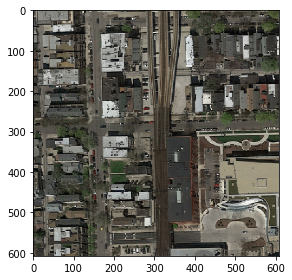

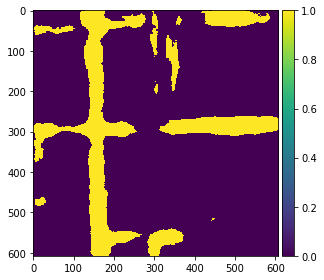

In [36]:
# Perform a sanity check on some random test samples
ix = random.randint(0, len(preds_test_t_s))
imshow(X_test_s[ix])
plt.show()
imshow(np.squeeze(preds_test_t_s[ix]))
plt.show()

In [37]:
preds_test_t_s = preds_test_t_s.reshape((50, 608, 608))
for i in range(50):
    imsave("results/test_" + str(i + 1) + ".png", preds_test_t_s[i]) #*255

FileNotFoundError: [Errno 2] No such file or directory: 'results/test_1.png'

In [ ]:
import re

foreground_threshold = 0.25 # percentage of pixels > 1 required to assign a foreground label to a patch

# assign a label to a patch
def patch_to_label(patch):
    df = np.mean(patch)
    if df > foreground_threshold:
        return 1
    else:
        return 0


def mask_to_submission_strings(image_filename):
    """Reads a single image and outputs the strings that should go into the submission file"""
    img_number = int(re.search(r"\d+", image_filename).group(0))
    im = imread(image_filename)
    patch_size = 16
    for j in range(0, im.shape[1], patch_size):
        for i in range(0, im.shape[0], patch_size):
            patch = im[i:i + patch_size, j:j + patch_size]
            label = patch_to_label(patch)
            yield("{:03d}_{}_{},{}".format(img_number, j, i, label))


def masks_to_submission(submission_filename, *image_filenames):
    """Converts images into a submission file"""
    with open(submission_filename, 'w') as f:
        f.write('id,prediction\n')
        for fn in image_filenames[0:]:
            print(str(fn))
            f.writelines('{}\n'.format(s) for s in mask_to_submission_strings(fn))


submission_filename = 'submission.csv'
image_filenames = []
for i in range(1, 51):
    image_filename = 'results/test_' + str(i) + '.png'
    print(image_filename)
    image_filenames.append(image_filename)
masks_to_submission(submission_filename, *image_filenames)

In [ ]:
import math
from PIL import Image

label_file = 'submission.csv'

h = 16
w = h
imgwidth = int(math.ceil((600.0/w))*w)
imgheight = int(math.ceil((600.0/h))*h)
nc = 3

# Convert an array of binary labels to a uint8
def binary_to_uint8(img):
    rimg = (img * 255).round().astype(np.uint8)
    return rimg

def reconstruct_from_labels(image_id):
    im = np.zeros((imgwidth, imgheight), dtype=np.uint8)
    f = open(label_file)
    lines = f.readlines()
    image_id_str = '%.3d_' % image_id
    for i in range(1, len(lines)):
        line = lines[i]
        if not image_id_str in line:
            continue

        tokens = line.split(',')
        id = tokens[0]
        prediction = int(tokens[1])
        tokens = id.split('_')
        i = int(tokens[1])
        j = int(tokens[2])

        je = min(j+w, imgwidth)
        ie = min(i+h, imgheight)
        if prediction == 0:
            adata = np.zeros((w,h))
        else:
            adata = np.ones((w,h))

        im[j:je, i:ie] = binary_to_uint8(adata)

    Image.fromarray(im).save('test/prediction_' + '%.3d' % image_id + '.png')

    return im

for i in range(1, 51):
    reconstruct_from_labels(i)

In [ ]:
def make_img_overlay(img, predicted_img):
    w = img.shape[0]
    h = img.shape[1]
    color_mask = np.zeros((w, h, 3), dtype=np.uint8)
    color_mask[:,:,0] = predicted_img*255

    img8 = img_float_to_uint8(img)
    background = Image.fromarray(img8, 'RGB').convert("RGBA")
    overlay = Image.fromarray(color_mask, 'RGB').convert("RGBA")
    new_img = Image.blend(background, overlay, 0.2)
    return new_img

In [ ]:
files = os.listdir("test/")
print("Loading " + str(len(files)) + " images")
imgs_test = [load_image_label("test/" + files[i]) for i in range(len(files))]
print(files[0])

ix = random.randint(0, 50)
plt.figure(figsize=(10, 10))
plt.imshow(make_img_overlay(X_test_s[ix], imgs_test[ix] * 255))